# Histopathologic Cancer Detection
#### Introduction to Deep Learning, University of Colorado, Boulder

This project endeavors to identify whether metastatic cancer is detectable in small image patches from digital pathology scans. The goal of the project is to predict whether a region of a patch contains at least one pixel of tumor tissue. 

The data and guidelines for this task are available on Kaggle, at the following link location:
> https://www.kaggle.com/competitions/histopathologic-cancer-detection

To accomplish this task, I will leverage Keras to train deep learning network for the purposes of image classification.  For the purposes of this project, I will experiment with three types of CNN architecture: VGG, Inception, and ResNet, and I will compare their performance using binary cross entropy loss, accuracy, recall, and precision. 

The project is also published on GitHub here: 
> https://github.com/slilly4/Cancer-Detection

In [1]:
import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, add, Input, concatenate
from keras import regularizers, optimizers
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

The Kaggle competition contains a folder of training images, a .csv file with training labels, a folder of test images, and a sample submission form.  I will store the locations of these files in variables so that they can be referenced later in the project as needed.

In [2]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test'
train_labels = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
sample_submission = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'

As all of the images are individual files located in a folder, it is necessary to load them into dataset to be used for training and validation. I initially tried to load the images using Kera's ImageDataGenerator class function flow_from_directory().  However, the images are not structured appropriately.  Therefore, I relied instead on flow_from_dataframe().  The image locations and labels are loaded into a dataframe, and the flow_from_dataframe() function uses that information to build the dataset.  

Assistance with this task comes from instructions here: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

I first loaded the training label file into a dataframe, and I appended the ".tif" file extension to each file name in the dataframe.  I also scaled the color values to be a value between 0 and 1 instead of 0 and 255.  An 80/20 train/test was also created so that we can measure performance. 

In [3]:
def append_extension(file_name):
    return file_name + ".tif"

train_df = pd.read_csv(train_labels,dtype=str)
test_df = pd.read_csv(sample_submission,dtype=str)

train_df["id"] = train_df["id"].apply(append_extension)
test_df["id"] = test_df["id"].apply(append_extension)

train_datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255.)

# Exporatory Data Analysis and Data Preparation

We can see below what the dataframe looks like.  There is a column for the image ID and the corresponding label.

In [4]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


Each .tif file includes what appears to be a microscopic image of a cell biopsy.  

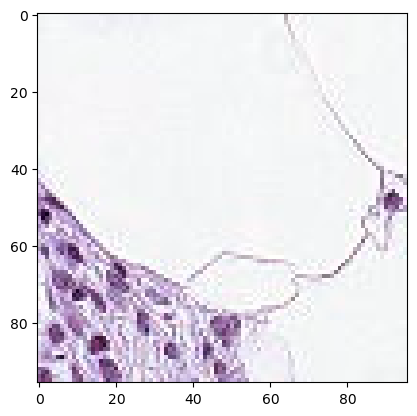

In [5]:
img = cv2.imread("/kaggle/input/histopathologic-cancer-detection/train/f38a6374c348f90b587e046aac6079959adf3835.tif")
plt.imshow(img)

The images are 96x96 pixels and they include three color channels.

In [6]:
img.shape

(96, 96, 3)

First we will sample some images that are not labeled as cancer

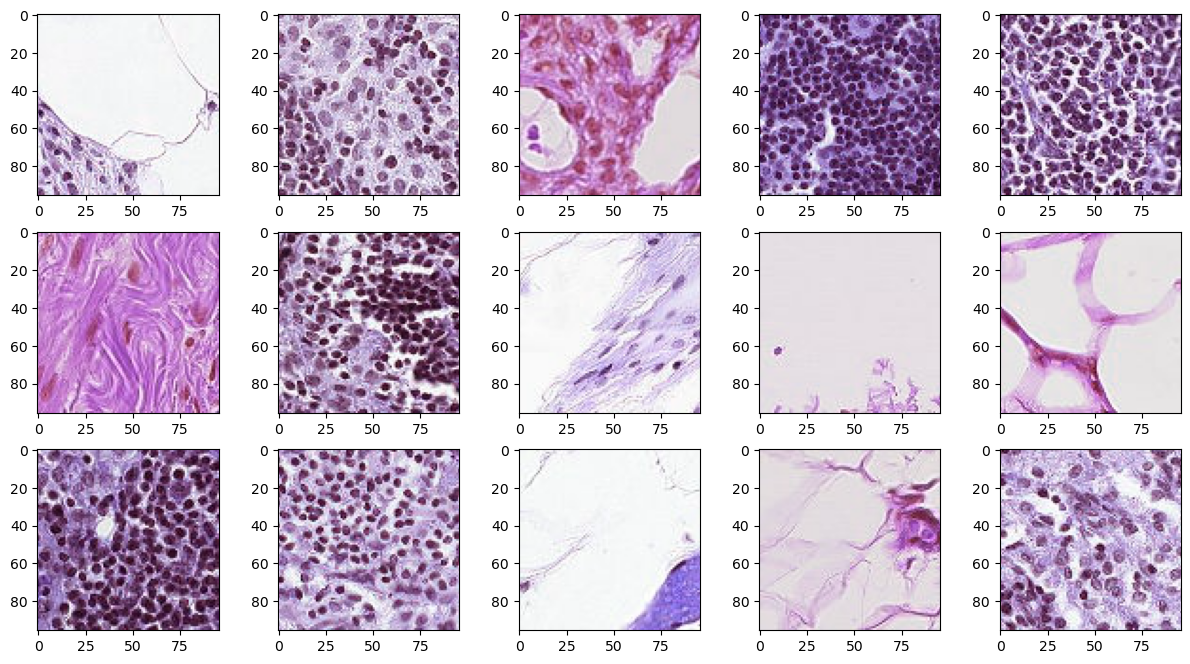

In [7]:
num_rows = 3
num_cols = 5
image_index = 0
image_location = train_df[train_df["label"] == "0"]["id"].head(15)

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,8))

for i in range(num_rows):
    for j in range(num_cols):  
        im = cv2.imread("/kaggle/input/histopathologic-cancer-detection/train/" + image_location.iloc[image_index])
        axes[i, j].imshow(im)
        image_index += 1

And now we will sample images that are labeled as cancer.

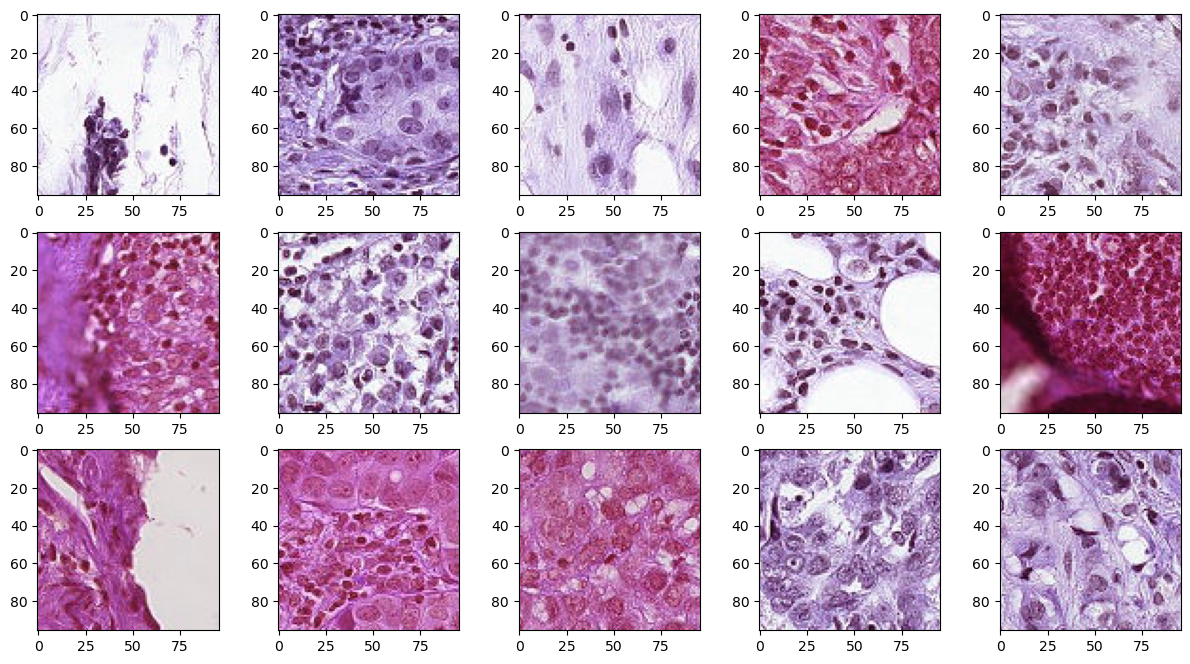

In [8]:
num_rows = 3
num_cols = 5
image_index = 0
image_location = train_df[train_df["label"] == "1"]["id"].head(15)

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,8))

for i in range(num_rows):
    for j in range(num_cols):  
        im = cv2.imread("/kaggle/input/histopathologic-cancer-detection/train/" + image_location.iloc[image_index])
        axes[i, j].imshow(im)
        image_index += 1

It is difficult to discern the patterns without being trained in medicine.  However, hopefully neural networks can identify them through the use of convolution and pooling.  The training images include 130,908 that are negative for cancer, while tere are 89,117 images that are positive for cancer.  Since there are only two label categories in the data, this will be a binary classification problem.

In [9]:
train_df.groupby('label').count()

,id
label,
0,130908
1,89117


<Axes: xlabel='label'>

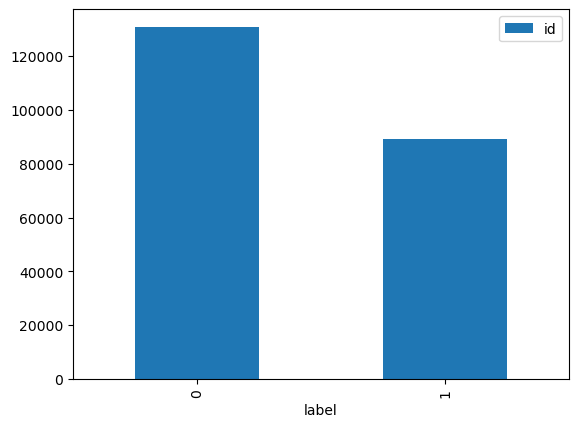

In [10]:
train_df.groupby('label').count().plot(kind='bar')

Below, I load the images from the test and train folders into datasets that can be used to train, validate, and test the models.  I will use batch sizes of 512 for the training, as hopefully this will help to speed up the train a little and also reduce some of the variance in the model.  I will also shuffle the training data, so that the images are not fed into the model in the same order as in the folders.  Lastly, I will keep the images as 96x96 pixels.  I will not attempt to reduce the size, so that we have as much information as possible present for the training.

In [12]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = "id",
    y_col = "label",
    subset = "training",
    batch_size = 512,
    seed = 9,
    shuffle = True,
    class_mode = "binary",
    target_size = (96,96))

valid_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col = "id",
    y_col = "label",
    subset = "validation",
    batch_size = 512,
    seed = 9,
    shuffle = True,
    class_mode = "binary",
    target_size = (96,96))

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = test_dir,
    x_col = "id",
    y_col = None,
    batch_size = 512,
    seed = 9,
    shuffle = False,
    class_mode = None,
    target_size = (96,96))

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


The following function will be used later in the project to assign binary classes to the Sigmoid transformed outputs.

In [11]:
def assign_binary_class(a):
    if a > .5:
        return 1
    else:
        return 0


# VGG Model

For a first attempt at training a model, I will use a VGG-style architecture.  Since I have limited computing capacity, the model will not include as many layers and filters as would be desirable; however, it is hoped that that four repeating layers of convolution and pooling can allow for decent performance.  My model will be composed of two convolution layers with 16 filters with a Max Pool layer, followed by two convolution layers with 32 filters with a Max Pool layer, followed by two convolution layers with 64 layers with a max pool layer, followed by two convolution layers with 128 filters followed by a max pool layer.  Then I will add two fully-connected dense layers to aid with classification.  At the end a sigmoid activation function will be used so that we have the possiblity of binary classification.  Accuracy, Precision, Recall, AUC will be used as metrics.  Adam will be used as an optimzer, as it is known to very computational efficient.

The following image was used as a guide for this model.  The filters were reduced as well as the total number of layers.  As it is composed, the model includes over 326,000 parameters.

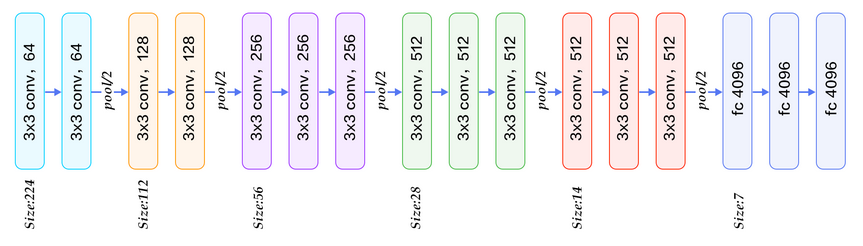

https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide

In [13]:
vgg_model = Sequential()
vgg_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation="relu", input_shape=(96,96,3)))
vgg_model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation="relu"))
vgg_model.add(MaxPooling2D(pool_size=(3, 3)))
vgg_model.add(Dense(128, activation="relu"))
vgg_model.add(Dense(128, activation="relu"))
vgg_model.add(GlobalAveragePooling2D())
vgg_model.add(Dense(1, activation="sigmoid"))
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    


In [14]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                    

I now train the model on the training dataset.  For all of the models I will initially use 10 epochs.  It takes quite a while to train the models, so I will see which model performs the strongest after 10 epochs, and then choose one to train further.

In [15]:
st = time.process_time()
vgg_stats = vgg_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=10)
et = time.process_time()
res = et - st
print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_23/2664028477.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg_stats = vgg_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=10)


Epoch 1/10
344/344 [==============================] - 1198s 3s/step - loss: 0.4686 - accuracy: 0.7794 - precision: 0.7561 - recall: 0.6727 - auc: 0.8517 - binary_accuracy: 0.7794 - val_loss: 0.3996 - val_accuracy: 0.8272 - val_precision: 0.8148 - val_recall: 0.7404 - val_auc: 0.8948 - val_binary_accuracy: 0.8272
Epoch 2/10
344/344 [==============================] - 362s 1s/step - loss: 0.3886 - accuracy: 0.8278 - precision: 0.8052 - recall: 0.7586 - auc: 0.9006 - binary_accuracy: 0.8278 - val_loss: 0.3467 - val_accuracy: 0.8528 - val_precision: 0.8573 - val_recall: 0.7625 - val_auc: 0.9239 - val_binary_accuracy: 0.8528
Epoch 3/10
344/344 [==============================] - 346s 1s/step - loss: 0.3443 - accuracy: 0.8506 - precision: 0.8348 - recall: 0.7873 - auc: 0.9225 - binary_accuracy: 0.8506 - val_loss: 0.3302 - val_accuracy: 0.8598 - val_precision: 0.8807 - val_recall: 0.7553 - val_auc: 0.9298 - val_binary_accuracy: 0.8598
Epoch 4/10
344/344 [==============================] - 352s 1

I will save the model in case it is desirable to add additional epochs in the future.

In [16]:
vgg_model.save('/kaggle/working/vgg_model.keras')

And now I will generate predictions for the test set to see how well the model performed on the competition dataset.

In [17]:
test_generator.reset()
vgg_predictions = vgg_model.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_23/2879509626.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vgg_predictions = vgg_model.predict_generator(test_generator,verbose=1)


113/113 [==============================] - 399s 4s/step


In [18]:
vgg_predictions_binary = np.apply_along_axis(assign_binary_class, 1, vgg_predictions)

In [19]:
submission_2 = test_df.copy()
submission_2["label"] = vgg_predictions_binary
submission_2['id'] = submission_2['id'].str.replace('.tif','')

/tmp/ipykernel_23/1780769181.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_2['id'] = submission_2['id'].str.replace('.tif','')


In [20]:
submission_2.to_csv('/kaggle/working/submission2.csv', index=False)

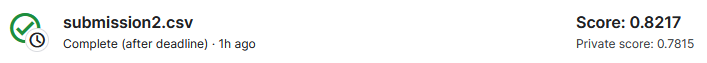

The VGG-style model performed decently well after 10 epochs of training.  The competition score is .8217; however, the private score (the other half of the predictions) did .04 worse.  

In [21]:
vgg_stats_list = []
for key, values in vgg_stats.history.items():
    vgg_stats_list.append((key,values))

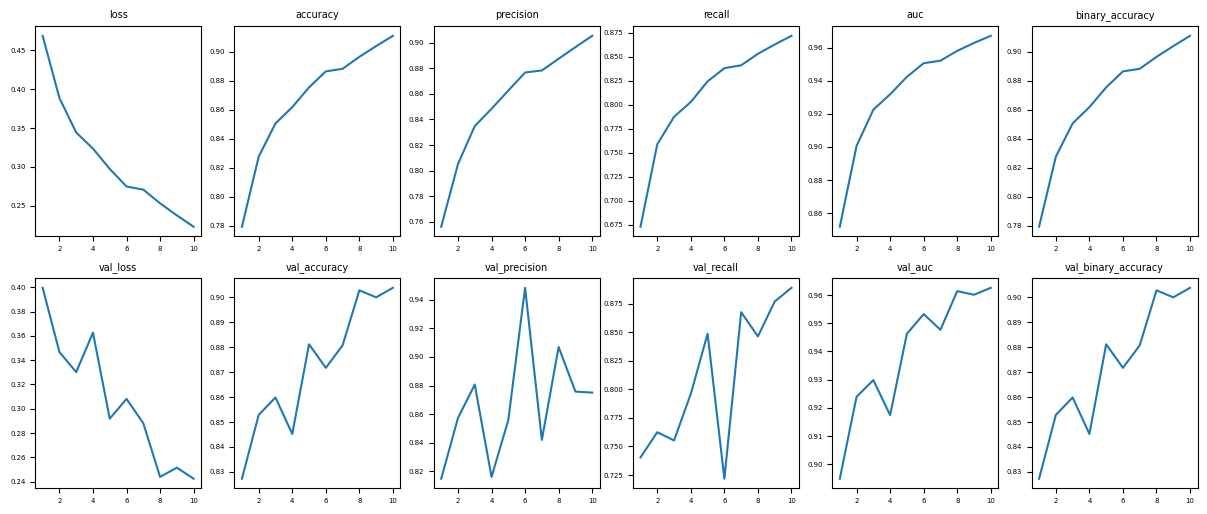

In [22]:
num_rows = 2
num_cols = 6
stat_index = 0

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,6))

for i in range(num_rows):
    for j in range(num_cols):  
        axes[i, j].plot(range(1,11),vgg_stats_list[stat_index][1])
        axes[i,j].set_title(vgg_stats_list[stat_index][0], fontsize=7)
        axes[i,j].xaxis.set_tick_params(labelsize=5)
        axes[i,j].yaxis.set_tick_params(labelsize=5)
        stat_index += 1



Interestingly, both the training and validation scores were much stronger than the Kaggle score.  This seems to be a bit strange.  I would assume that the Kaggle competition score would be comparable to the validation accuracy, but that is not the case.  After 10 epochs, the validation accuracy is over .9, while both the precision and recall achieved scores of around .88.  The Area Under the Curve (AUC) of the ROC curve was about .96 for the validation test set.  

Overall there was strong improvement over the successive epochs.  The validation graphs are a bit choppy, but there is an upward trend towards improvement.

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.2230 | 0.2423 |
|Accuracy | 0.9110 | 0.9039 |
|Precision | 0.9054 | 0.8750 | 
|Recall | 0.8716 | 0.8889 |
|AUC | 0.9673 | 0.9626 | 


# Inception Model

The Inception architecture was developed by Google, and it includes parallel convolution with different size filters and pooling.  It is noted for reducing the amount of computation needed.  However, I found that adding more than two blocks of filters led to Out of Memory and Resource errors.  Some of the matrixes were just too big.  Therefore, I limited myself to only 2 inception blocks, and I reduced the number of filters present on each layer.   

Inspiration for my implementation of the model comes from: https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/ and our class lectures.  Each block in the model has the following structure:



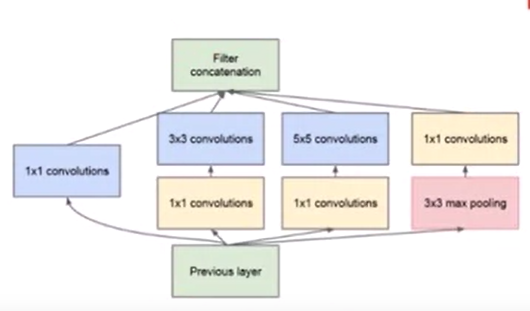

Similar to the VGG style model, I will add a sigmoid activation function at the end so that we can produce a binary result.  Adam will be used as an optimizer due to its computational efficiency and binary crossentropy will be suitable for this binary classification task.  

I will track performance with Accuracy, Precision, Recall, and AUC.

Overall this model has about 50,000 parameters.  This is many fewer than the VGG-style model, but this one took twice as long to train over 10 epochs.

In [24]:
layer_in = Input(shape=(96, 96, 3))

# This is for the first column of layers:  A 1x1 Convolution
col1 = Conv2D(16, (1,1), padding='same', activation='relu')(layer_in)

# This is for the second column of layers: A 1x1 Convolution which flows into a 3x3 convolution
col2 = Conv2D(24, (1,1), padding='same', activation='relu')(layer_in)
col2 = Conv2D(32, (3,3), padding='same', activation='relu')(col2)

# This is for the third column of layers: A 1x1 Convolution which flows into a 5x5 convolution
col3 = Conv2D(8, (1,1), padding='same', activation='relu')(layer_in)
col3 = Conv2D(16, (5,5), padding='same', activation='relu')(col3)

# This is for the fourth column of layers: A 3x3 Max Pool which flows into a 1x1 convolution
col4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
col4 = Conv2D(16, (1,1), padding='same', activation='relu')(col4)

# This concatenates the four columns of layers
layer_out = concatenate([col1, col2, col3, col4], axis=-1)

#This repeats the process for a second time:

# This is for the first column of layers:  A 1x1 Convolution
col1_2 = Conv2D(32, (1,1), padding='same', activation='relu')(layer_out)

# This is for the second column of layers: A 1x1 Convolution which flows into a 3x3 convolution
col2_2 = Conv2D(48, (1,1), padding='same', activation='relu')(layer_out)
col2_2 = Conv2D(64, (3,3), padding='same', activation='relu')(col2_2)

# This is for the third column of layers: A 1x1 Convolution which flows into a 5x5 convolution
col3_2 = Conv2D(8, (1,1), padding='same', activation='relu')(layer_out)
col3_2 = Conv2D(16, (5,5), padding='same', activation='relu')(col3_2)

# This is for the fourth column of layers: A 3x3 Max Pool which flows into a 1x1 convolution
col4_2 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_out)
col4_2 = Conv2D(16, (1,1), padding='same', activation='relu')(col4_2)

# This concatenates the four columns of layers
layer_out_2 = concatenate([col1_2, col2_2, col3_2, col4_2], axis=-1)

layer_out_2 = GlobalAveragePooling2D()(layer_out_2)
layer_out_2 = Dense(1, activation="sigmoid")(layer_out_2)

inception_model = Model(inputs=layer_in, outputs=layer_out_2)
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
    
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 96, 96, 24)   96          ['input_1[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 96, 96, 8)    32          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 96, 96, 3)   0           ['input_1[0][0]']                
                                                                                              

In [25]:
st = time.process_time()
inception_stats = inception_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=10)
et = time.process_time()
print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_23/206001380.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  inception_stats = inception_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=10)


Epoch 1/10
344/344 [==============================] - 477s 1s/step - loss: 0.5006 - accuracy: 0.7617 - precision_1: 0.7520 - recall_1: 0.6148 - auc_1: 0.8287 - binary_accuracy: 0.7617 - val_loss: 0.4566 - val_accuracy: 0.7923 - val_precision_1: 0.7826 - val_recall_1: 0.6725 - val_auc_1: 0.8616 - val_binary_accuracy: 0.7923
Epoch 2/10
344/344 [==============================] - 382s 1s/step - loss: 0.4415 - accuracy: 0.8009 - precision_1: 0.7749 - recall_1: 0.7171 - auc_1: 0.8696 - binary_accuracy: 0.8009 - val_loss: 0.4170 - val_accuracy: 0.8203 - val_precision_1: 0.8085 - val_recall_1: 0.7274 - val_auc_1: 0.8868 - val_binary_accuracy: 0.8203
Epoch 3/10
344/344 [==============================] - 380s 1s/step - loss: 0.4050 - accuracy: 0.8215 - precision_1: 0.7997 - recall_1: 0.7466 - auc_1: 0.8910 - binary_accuracy: 0.8215 - val_loss: 0.3788 - val_accuracy: 0.8359 - val_precision_1: 0.8005 - val_recall_1: 0.7907 - val_auc_1: 0.9067 - val_binary_accuracy: 0.8359
Epoch 4/10
344/344 [=====

I will save the model in case there is a need to conduct further training.  

In [26]:
inception_model.save('/kaggle/working/inception_model.keras')

And now I will produce predictions for the Kaggle test set. 

In [27]:
test_generator.reset()
incept_predictions = inception_model.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_23/3582621647.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  incept_predictions = inception_model.predict_generator(test_generator,verbose=1)


113/113 [==============================] - 148s 1s/step


In [28]:
incept_predictions_binary = np.apply_along_axis(assign_binary_class, 1, incept_predictions)

In [29]:
submission_3 = test_df.copy()
submission_3["label"] = incept_predictions_binary
submission_3['id'] = submission_3['id'].str.replace('.tif','')

/tmp/ipykernel_23/1406146359.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_3['id'] = submission_3['id'].str.replace('.tif','')


In [30]:
submission_3.to_csv('/kaggle/working/submission3.csv', index=False)

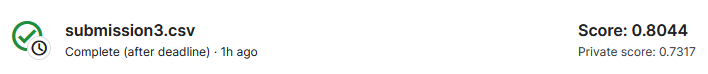

The Inception model performed much worse than the VGG-style model after 10 epochs.  While the official score is .8044 on Kaggle, the private score (the other 50% of the test data) produced a score of .73.  This is nearly 10% worse than the VGG.  Also as mentioned, training took twice as long.   

In [32]:
incept_stats_list = []
for key, values in inception_stats.history.items():
    incept_stats_list.append((key,values))

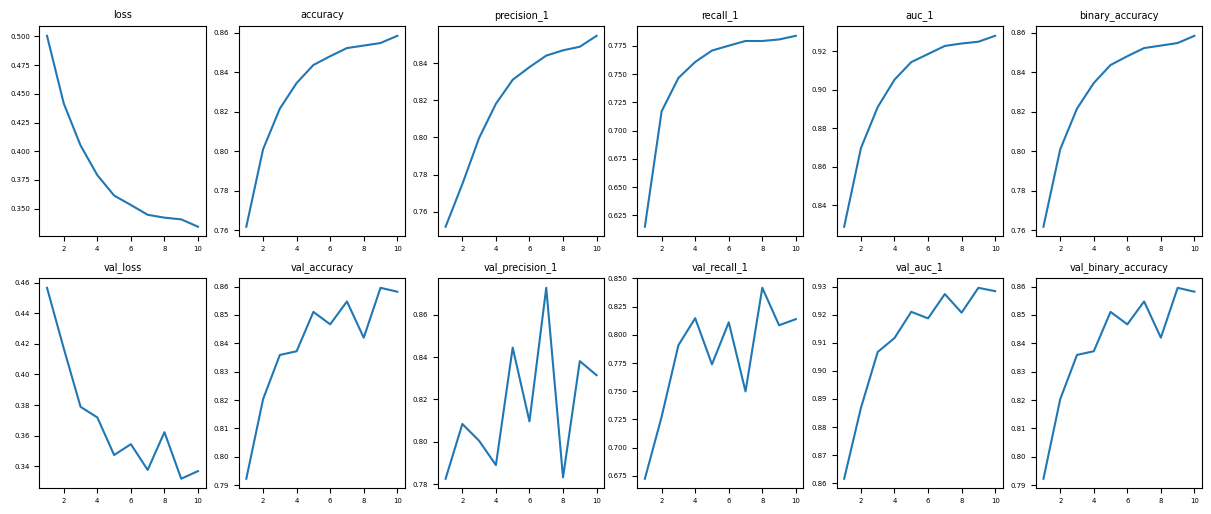

In [33]:
num_rows = 2
num_cols = 6
stat_index = 0

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,6))

for i in range(num_rows):
    for j in range(num_cols):  
        axes[i, j].plot(range(1,11),incept_stats_list[stat_index][1])
        axes[i,j].set_title(incept_stats_list[stat_index][0], fontsize=7)
        axes[i,j].xaxis.set_tick_params(labelsize=5)
        axes[i,j].yaxis.set_tick_params(labelsize=5)
        stat_index += 1

Accuracy did increase over the 10 epochs; however, the graphs suggest that the performance is beginning to plateau at about .86.  The validation AUC is about .93 after 10 epochs, while recall is about .82.  Interestingly, the Training recall is worse at ~.775. 

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.3341 | 0.3369 |
|Accuracy | 0.8584 | 0.8582 |
|Precision | 0.8546 | 0.8314 | 
|Recall | 0.7840 | 0.8138 |
|AUC | 0.9280 | 0.9284 | 

# ResNet Model

Lastly, I will attempt this image classification problem by using a ResNet-style architecture.  Such an architecture is also noted for improving efficiency and reducing the risk of exploding/vanishing gradient.  The ResNet includes "skips" between the layers, allowing for deeper neural networks.  The following images provides a diagram of one implementation of ResNet.

Again I had issues with trying to implement such an architecture due to Resource and OOM errors.  I settled for an architecture with 4 blocks.  Each of these blocks includes one path with two convolution layers which is then merged with the input layer.  To keep the sizes appropriate, the input layer is put through a 1x1 filter. At the end average pooling is used, and a sigmoid activation function is employed to allow for a binary result. I kept my filter sizes much smaller due to memory issues.  The first block includes filters of 16, while subsequent blocks have sizes of 32 and 64.  

Inspiration for my implementation of the model comes from: https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/ and our class lectures.  

Overall, there are more than 150,000 parameters in this model.  This model took the longest of the three of train on 10 epochs.

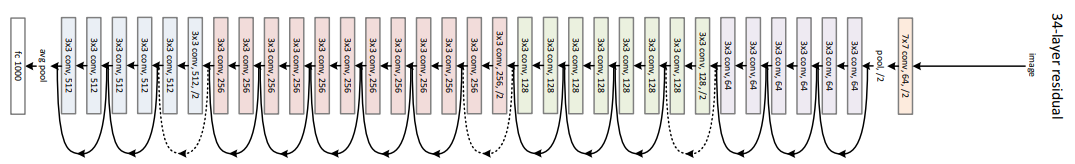

https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/#

In [34]:
#Input Layer
layer_in = Input(shape=(96, 96, 3))


# Layer 1

# One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
merge_input = Conv2D(16, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)

# Two Convolution layers
conv1 = Conv2D(16, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
conv2 = Conv2D(16, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)

# Add the Convolution output and the original input and add the Activation function
layer_out = add([conv2, merge_input])
layer_out = Activation('relu')(layer_out)


# Layer 2

# One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
merge_input_1 = Conv2D(32, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out)

# Two Convolution layers
conv1_1 = Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out)
conv2_1 = Conv2D(32, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1_1)

# Add the Convolution output and the original input and add the Activation function
layer_out_1 = add([conv2_1, merge_input_1])
layer_out_1 = Activation('relu')(layer_out_1)


# Layer 3

# One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
merge_input_2 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_1)

# Two Convolution layers
conv1_2 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_1)
conv2_2 = Conv2D(64, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1_2)

# Add the Convolution output and the original input and add the Activation function
layer_out_2 = add([conv2_2, merge_input_2])
layer_out_2 = Activation('relu')(layer_out_2)


# Layer 4

# One layer that skips the Convolutions.  A 1x1 Convolution is used to match the sizes.
merge_input_3 = Conv2D(64, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_2)

# Two Convolution layers
conv1_3 = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_out_2)
conv2_3 = Conv2D(64, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1_3)

# Add the Convolution output and the original input and add the Activation function
layer_out_3 = add([conv2_3, merge_input_3])
layer_out_3 = Activation('relu')(layer_out_3)

pool = AveragePooling2D((3,3), strides=(1,1), padding='same')(layer_out_3)
global_pool = GlobalAveragePooling2D()(pool)
layer_out_6 = Dense(1, activation="sigmoid")(global_pool)

resnet_model = Model(inputs=layer_in, outputs=layer_out_6)
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC(),tf.keras.metrics.BinaryAccuracy()])
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 96, 96, 16)   448         ['input_2[0][0]']                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 96, 96, 16)   2320        ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 96, 16)   64          ['input_2[0][0]']                
                                                                                            

In [35]:
st = time.process_time()
resnet_stats = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=10)
et = time.process_time()
print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_23/3923264308.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_stats = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=10)


Epoch 1/10
344/344 [==============================] - 549s 2s/step - loss: 0.5653 - accuracy: 0.7640 - precision_2: 0.7399 - recall_2: 0.6441 - auc_2: 0.8270 - binary_accuracy: 0.7640 - val_loss: 0.4513 - val_accuracy: 0.7969 - val_precision_2: 0.8269 - val_recall_2: 0.6287 - val_auc_2: 0.8735 - val_binary_accuracy: 0.7969
Epoch 2/10
344/344 [==============================] - 423s 1s/step - loss: 0.4217 - accuracy: 0.8095 - precision_2: 0.7921 - recall_2: 0.7187 - auc_2: 0.8817 - binary_accuracy: 0.8095 - val_loss: 0.3827 - val_accuracy: 0.8306 - val_precision_2: 0.8404 - val_recall_2: 0.7166 - val_auc_2: 0.9056 - val_binary_accuracy: 0.8306
Epoch 3/10
344/344 [==============================] - 414s 1s/step - loss: 0.3875 - accuracy: 0.8295 - precision_2: 0.8193 - recall_2: 0.7432 - auc_2: 0.9020 - binary_accuracy: 0.8295 - val_loss: 0.3619 - val_accuracy: 0.8434 - val_precision_2: 0.8423 - val_recall_2: 0.7533 - val_auc_2: 0.9149 - val_binary_accuracy: 0.8434
Epoch 4/10
344/344 [=====

I will save the model in case there is a need to train it further.  

In [36]:
resnet_model.save('/kaggle/working/resnet_model.keras')

Now I will generate predictions for the test data.

In [37]:
test_generator.reset()
resnet_predictions = resnet_model.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_23/522738418.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  resnet_predictions = resnet_model.predict_generator(test_generator,verbose=1)


113/113 [==============================] - 152s 1s/step


In [38]:
resnet_predictions_binary = np.apply_along_axis(assign_binary_class, 1, resnet_predictions)

In [39]:
submission_4 = test_df.copy()
submission_4["label"] = resnet_predictions_binary
submission_4['id'] = submission_4['id'].str.replace('.tif','')

/tmp/ipykernel_23/268334198.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_4['id'] = submission_4['id'].str.replace('.tif','')


In [40]:
submission_4.to_csv('/kaggle/working/submission4.csv', index=False)

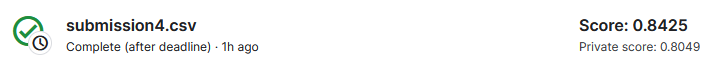

Of the 3 models, the ResNet style model performed the best on the Kaggle competition after 10 epochs on training.  However, the VGG model performed slightly better on the validation data, while being trained in less than half the time.  

In [41]:
resnet_stats_list = []
for key, values in resnet_stats.history.items():
    resnet_stats_list.append((key,values))

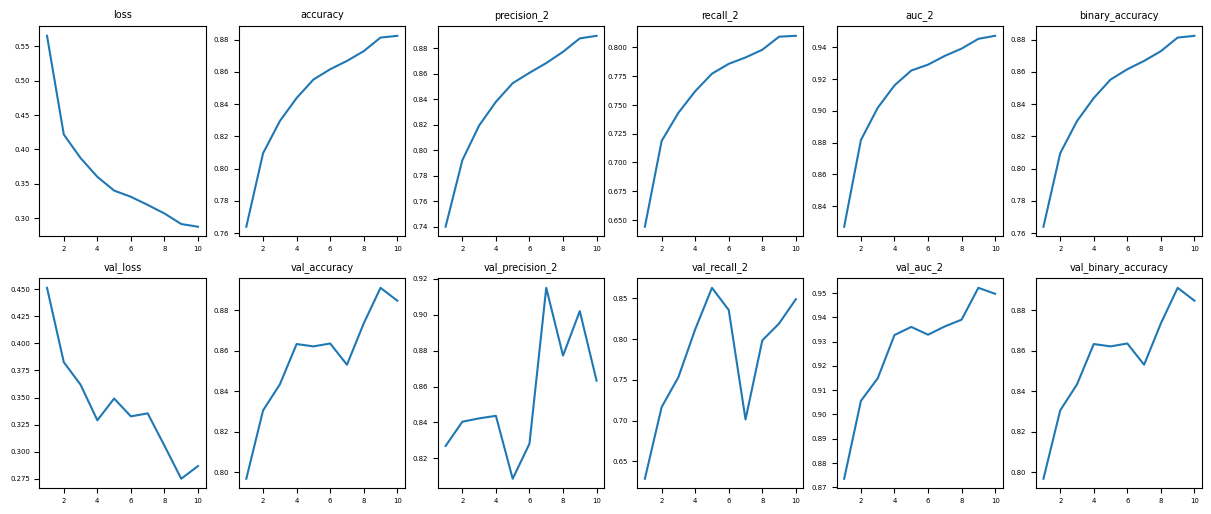

In [42]:
num_rows = 2
num_cols = 6
stat_index = 0

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,6))

for i in range(num_rows):
    for j in range(num_cols):  
        axes[i, j].plot(range(1,11),resnet_stats_list[stat_index][1])
        axes[i,j].set_title(resnet_stats_list[stat_index][0], fontsize=7)
        axes[i,j].xaxis.set_tick_params(labelsize=5)
        axes[i,j].yaxis.set_tick_params(labelsize=5)
        stat_index += 1

Again, the graphs show that there is an overall positive trend towards improved performance over the epochs.  The Accuracy is about .88 for both training and validation, and the AUC peaks at about .95 for the validation data.  

|Metric|Training|Validation|
|:----|:--------:|:--------:|
|Loss | 0.2875 | 0.2867 |
|Accuracy | 0.8823 | 0.8846 |
|Precision | 0.8896 | 0.8633 | 
|Recall | 0.8101 | 0.8488 |
|AUC | 0.9473 | 0.9497 | 

# Additional Training

As the ResNet-style model performed the best on the Kaggle competition, I will run additional epochs of training to see whether the performance can be enhanced further.  

In [43]:
st = time.process_time()
resnet_stats_2 = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=10)
et = time.process_time()
print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_23/3949950391.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_stats_2 = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=10)


Epoch 1/10
344/344 [==============================] - 414s 1s/step - loss: 0.2769 - accuracy: 0.8879 - precision_2: 0.8953 - recall_2: 0.8193 - auc_2: 0.9510 - binary_accuracy: 0.8879 - val_loss: 0.2665 - val_accuracy: 0.8930 - val_precision_2: 0.9185 - val_recall_2: 0.8067 - val_auc_2: 0.9577 - val_binary_accuracy: 0.8930
Epoch 2/10
344/344 [==============================] - 413s 1s/step - loss: 0.2651 - accuracy: 0.8931 - precision_2: 0.9006 - recall_2: 0.8277 - auc_2: 0.9551 - binary_accuracy: 0.8931 - val_loss: 0.2533 - val_accuracy: 0.8963 - val_precision_2: 0.9407 - val_recall_2: 0.7931 - val_auc_2: 0.9612 - val_binary_accuracy: 0.8963
Epoch 3/10
344/344 [==============================] - 413s 1s/step - loss: 0.2551 - accuracy: 0.8979 - precision_2: 0.9062 - recall_2: 0.8346 - auc_2: 0.9584 - binary_accuracy: 0.8979 - val_loss: 0.2416 - val_accuracy: 0.9032 - val_precision_2: 0.9274 - val_recall_2: 0.8248 - val_auc_2: 0.9626 - val_binary_accuracy: 0.9032
Epoch 4/10
344/344 [=====

In [44]:
resnet_model.save('/kaggle/working/resnet_model2.keras')

In [45]:
test_generator.reset()
resnet_predictions_2 = resnet_model.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_23/3240566357.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  resnet_predictions_2 = resnet_model.predict_generator(test_generator,verbose=1)


113/113 [==============================] - 150s 1s/step


In [46]:
resnet_predictions_binary_2 = np.apply_along_axis(assign_binary_class, 1, resnet_predictions_2)

In [47]:
submission_5 = test_df.copy()
submission_5["label"] = resnet_predictions_binary_2
submission_5['id'] = submission_5['id'].str.replace('.tif','')

/tmp/ipykernel_23/2291949949.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_5['id'] = submission_5['id'].str.replace('.tif','')


In [48]:
submission_5.to_csv('/kaggle/working/submission5.csv', index=False)

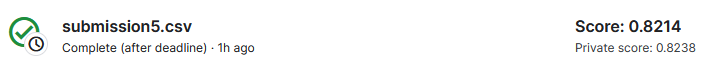

After 20 total epochs the ResNet-style model actually performed worse on the public score, but it performed about .02 better on the private score.  

In [50]:
resnet_stats_list_2 = []
for key, values in resnet_stats_2.history.items():
    resnet_stats_list_2.append((key,values))

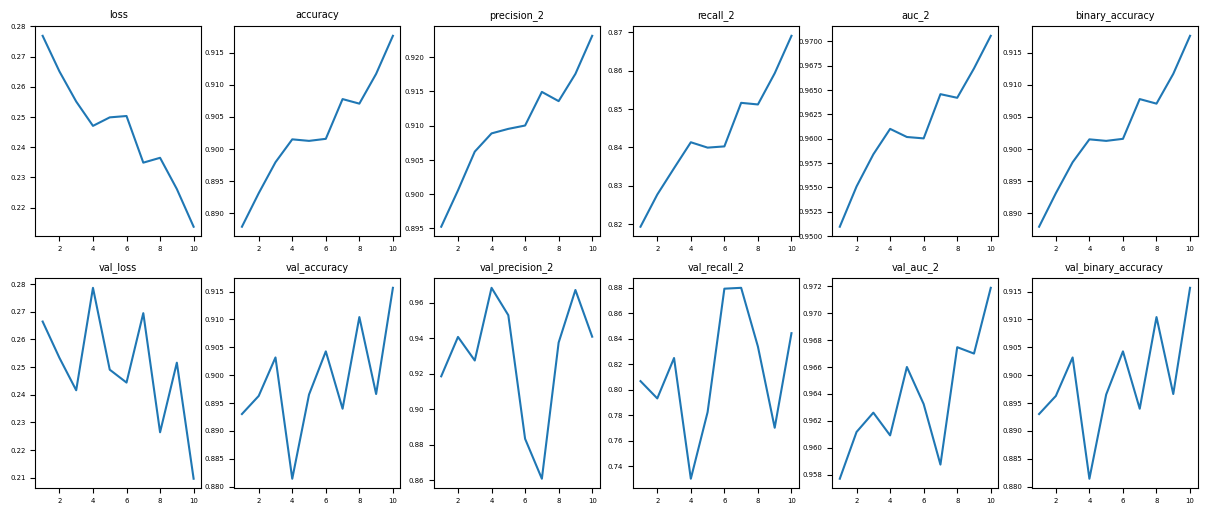

In [51]:
num_rows = 2
num_cols = 6
stat_index = 0

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,6))

for i in range(num_rows):
    for j in range(num_cols):  
        axes[i, j].plot(range(1,11),resnet_stats_list_2[stat_index][1])
        axes[i,j].set_title(resnet_stats_list[stat_index][0], fontsize=7)
        axes[i,j].xaxis.set_tick_params(labelsize=5)
        axes[i,j].yaxis.set_tick_params(labelsize=5)
        stat_index += 1

The graphs show that validation scores actually were much more variable with these additional epochs.  While there is a overall upward trend on accuray, precision and recall, there is a bit of fluctuation.  It is good to see that the loss dropped by about .06 over the course of the epochs.  I will train the model for another 10 epochs to see whether the trends continue to improve or not.  

In [52]:
st = time.process_time()
resnet_stats_3 = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=10)
et = time.process_time()
print('Execution time:', et - st, 'seconds')

/tmp/ipykernel_23/1628754442.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_stats_3 = resnet_model.fit_generator(generator = train_generator, validation_data = valid_generator, epochs=10)


Epoch 1/10
344/344 [==============================] - 425s 1s/step - loss: 0.2214 - accuracy: 0.9145 - precision_2: 0.9205 - recall_2: 0.8637 - auc_2: 0.9685 - binary_accuracy: 0.9145 - val_loss: 0.2132 - val_accuracy: 0.9201 - val_precision_2: 0.9151 - val_recall_2: 0.8844 - val_auc_2: 0.9709 - val_binary_accuracy: 0.9201
Epoch 2/10
344/344 [==============================] - 406s 1s/step - loss: 0.2138 - accuracy: 0.9180 - precision_2: 0.9235 - recall_2: 0.8696 - auc_2: 0.9704 - binary_accuracy: 0.9180 - val_loss: 0.2700 - val_accuracy: 0.8866 - val_precision_2: 0.9501 - val_recall_2: 0.7591 - val_auc_2: 0.9585 - val_binary_accuracy: 0.8866
Epoch 3/10
344/344 [==============================] - 405s 1s/step - loss: 0.2133 - accuracy: 0.9182 - precision_2: 0.9234 - recall_2: 0.8705 - auc_2: 0.9706 - binary_accuracy: 0.9182 - val_loss: 0.3161 - val_accuracy: 0.8623 - val_precision_2: 0.9820 - val_recall_2: 0.6713 - val_auc_2: 0.9659 - val_binary_accuracy: 0.8623
Epoch 4/10
344/344 [=====

In [53]:
resnet_model.save('/kaggle/working/resnet_model3.keras')

In [54]:
test_generator.reset()
resnet_predictions_3 = resnet_model.predict_generator(test_generator,verbose=1)

/tmp/ipykernel_23/499058435.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  resnet_predictions_3 = resnet_model.predict_generator(test_generator,verbose=1)


113/113 [==============================] - 145s 1s/step


In [55]:
resnet_predictions_binary_3 = np.apply_along_axis(assign_binary_class, 1, resnet_predictions_3)

In [56]:
submission_6 = test_df.copy()
submission_6["label"] = resnet_predictions_binary_3
submission_6['id'] = submission_5['id'].str.replace('.tif','')

/tmp/ipykernel_23/1167027604.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_6['id'] = submission_5['id'].str.replace('.tif','')


In [57]:
submission_6.to_csv('/kaggle/working/submission6.csv', index=False)

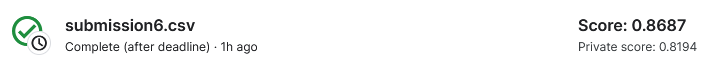

It is encouraging to see that the model improved on the competition test set.  Though the private score actually decreased, and this creates some doubt about whether we can indeed understand this as a solid improvement. 

In [58]:
resnet_stats_list_3 = []
for key, values in resnet_stats_3.history.items():
    resnet_stats_list_3.append((key,values))

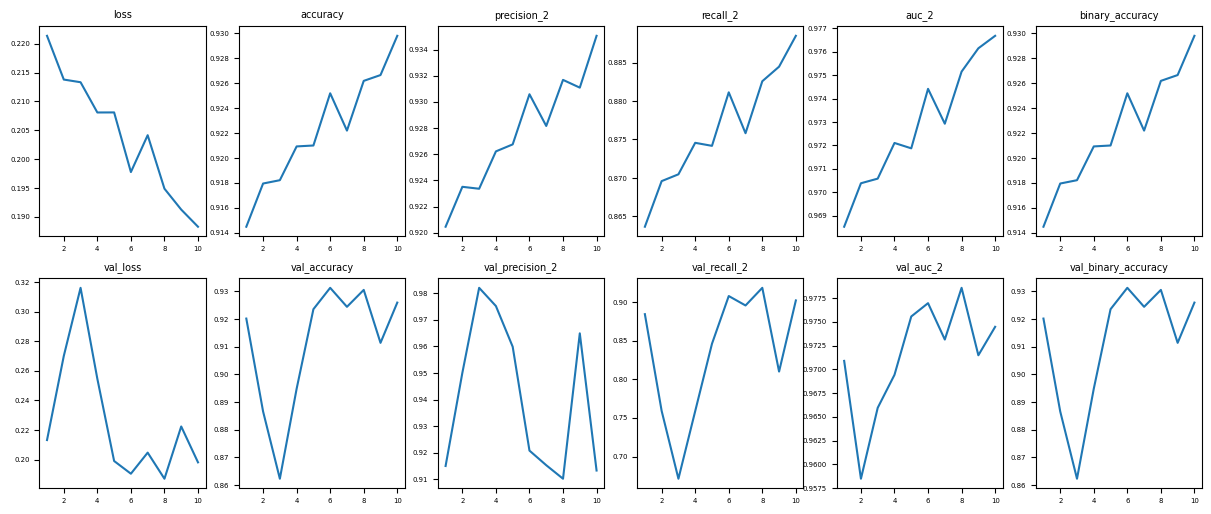

In [59]:
num_rows = 2
num_cols = 6
stat_index = 0

fig, axes = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (15,6))

for i in range(num_rows):
    for j in range(num_cols):  
        axes[i, j].plot(range(1,11),resnet_stats_list_3[stat_index][1])
        axes[i,j].set_title(resnet_stats_list_3[stat_index][0], fontsize=7)
        axes[i,j].xaxis.set_tick_params(labelsize=5)
        axes[i,j].yaxis.set_tick_params(labelsize=5)
        stat_index += 1

While the training graphs clearly show improvement, the validation graphs suggest a stagnation.  There is very little improvement over the 10 epochs.  

# Analysis and Discussion

After 10 epochs, the models performed as follows:

|Metric|VGG|Inception|ResNet|
|:----|:--------:|:--------:|:--------:|
|Loss | 0.2423 | 0.3369 | 0.2867 |
|Accuracy | 0.9039 | 0.8582 | 0.8846 |
|Precision |  0.8750 | 0.8314 | 0.8633 | 
|Recall | 0.8889 | 0.8138 | 0.8488 |
|AUC | 0.9626 | 0.9284 | 0.9497 | 
|Kaggle | 0.8217 | 0.8044 | 0.8425 | 
|Computation Time | 2619 | 4101 | 4887 |
|# Parameters | 326,673 | 49,897 | 152,881 |

While the VGG-style model had the greatest number of parameters, it actually trained in the least amount of time.  It also performed the best on the validation data, showing the least amount of loss among the models, and scored the highest on accuracy, precision, recall and AUC.  

The ResNet-style model had the second highest number of parameters; however, its training time was nearly twice as long as the VGG.  It also scored second best on all of the validation metrics.  However, it did perform better on the Kaggle competion test data.  

The Inception model had the least amount of parameters, but it, as well, took much longer to train than the VGG model.  It performed the worst on the validation data and on the Kaggle competition.

The ease of implementing the VGG model (its architecture is quite simple) and its performance make it an ideal candidate for more investigation in the future.  It could be possible to add additional convolution and pooling layers, though doing so risks a vanishing gradient.  That is one of the strengths of a model like ResNet which incorporate skips between layers.  However, resource constraints did not allow me to get the full benefit of ResNet.  I couldn't implement a deeper model because of OOM problems.  That may also have been the issue with the Inception style mode.  I was only able to implement two blocks of layers.  This was not enough to successfully train.  The VGG-style model had 4 blocks of convolution and pooling, while the ResNet also had 4.

The results also suggest that the presence of more fully connected layers near the output of the model could improve performance.  However, these quickly add to the parameter count and memory needs.  My VGG-style model included two fully connect layers, while the other two models did not.  This increased the number of parameters, but also likely increased performance.

The improvement of these models is very challenging due to the time involved in training the models.  Just to complete 10 epochs of training takes hours of time, depending on the architecture.  Therefore, it is difficult to attempt to tune parameters and understand the impact.  The models also show quite a bit of variation between epochs, and it is not prudent to judge the performance just based on a few epochs on training.  Neural network tutorials online suggest that it may be necessary to train for more than 100 epochs to see real results of a particular model and architecture.

Based on the loss graphs of the models, it is clear that the models do have room to improve through additional training.  There is not any clear flatlining of the loss, which suggests that more can be done.  

Architecture changes are also challenging due to resource contraints.  Nearly all of my models ran up again OOM and Resource errors when first attempting to train them.  It was necessary to scale them back in order to train them.  

One place to potentially improve the model is through the learning rate.  The models are slow to train, so increasing the learning rate potentially could improve the speed of training.  The inital rate for the Adam optimizer is currently .001 and Adam does implement a decay.  This is acceptable for many tasks, but this one might benefit from a higher initial learning rate here. 

Another place for improvement may lie with the number of filters.  I generally started with fewer filters in the first layers of the model and increase the number in the subsequent layers.  I hoped that this would allow for the identification of features of different sizes, but more experimentation would be needed to identify the best arrangement.   

# Conclusion

Through through Kaggle competition, I attempted to implement three different Convolutional Neural Network architectures in order to train a model to predict whether a given medical scan shows the presence of cancer.  Using architectures inspired by VGG, Inception, and ResNet, I was able to score a .86 Accuracy on the Kaggle test data.  While ResNet performed the best, VGG showed the most promise for further improvement.  Even though it had the most parameters in the model, it trained in the least amount of time while performing the best on the validation data.  Initial findings suggest that deeper models work better and that multiple fully connected layers near the output are indispensible.  